**Deadline**: 30.10.2024 19:00 (GMT+3)

## Part I: Implement 2048 environment (6 points)

In this homework our goal is implement and solve [2048 game](https://en.wikipedia.org/wiki/2048_(video_game)). If you are not familiar with it, it's highly recommended to play some games (e.g. [here](https://2048game.com/)).

One of the most interesting question that you probably will ask yourself during solving this task is "How to design reward function here?". You can use the [reward function from the origin game](https://en.wikipedia.org/wiki/2048_(video_game)#:~:text=The%20user's%20score%20starts%20at,that%20to%20reach%20higher%20scores.) or you can use it as inspiration for developing your own reward function. Think about what is "good" reward function in this context. 

Implementation **must be consistent** with gymnasium interfaces. Keep in mind that all tests passed is requirement for achiving non-zero score for this task.

Below you can find tests that may help you with implementation.

In [556]:
%load_ext autoreload
%autoreload 2

import numpy as np
from env import Game2048Env

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [557]:
env = Game2048Env(render_mode='ansi')
print(env.render())

Score: 0
Highest: 2
[[0 0 0 0]
 [0 0 0 0]
 [2 0 0 0]
 [2 0 0 0]]

Score: 0
Highest: 2
[[0 0 0 0]
 [0 0 0 0]
 [2 0 0 0]
 [2 0 0 0]]



In [558]:
assert env.get_board().shape == (4, 4)

In [1011]:
test_left = np.array([[2, 0, 2, 4], [2, 2, 2, 2], [4, 8, 0, 16], [8, 16, 4, 0]])
answer = np.array([[4, 4, 0, 0], [4, 4, 0, 0], [4, 8, 16, 0], [8, 16, 4, 0]])

env.set_board(test_left)
env.render()
score = env.move(3)
env.render()
assert np.allclose(env.get_board(), answer)
assert np.allclose(score, 12)

In [1012]:
test_left = np.array([[2, 0, 2, 4], [2, 2, 2, 2], [4, 8, 0, 16], [8, 16, 4, 0]])
test_left = np.array([[2, 0, 2, 4], [2, 2, 2, 2], [4, 8, 0, 16], [0, 0, 0, 0]])
answer = np.array([[4, 4, 0, 0], [4, 4, 0, 0], [4, 8, 16, 0], [8, 16, 4, 0]])

env.set_board(test_left)
print(env.get_board())
score = env.move(3)
print(env.get_board())
score = env.move(3)
print(env.get_board())
score = env.move(3)
print(env.get_board())

[[ 2  0  2  4]
 [ 2  2  2  2]
 [ 4  8  0 16]
 [ 0  0  0  0]]
[[ 4  4  0  0]
 [ 4  4  0  0]
 [ 4  8 16  0]
 [ 0  0  0  0]]
[[ 8  0  0  0]
 [ 8  0  0  0]
 [ 4  8 16  0]
 [ 0  0  0  0]]


IllegalMove: 

## Part II: Implement CEM (4 points)

In this task, your goal is to train the CEM algorithm to solve your own environment. Try any tricks you learned in the webinars. You will solve the task if your solution can reach 1024 as a max tile.

In [561]:
import torch
import torch.nn as nn
import torch.optim as optim

In [1013]:
def get_channels(matrix, size=4):
    channels = []
    for i in range(1, 11):
        batch = np.zeros((size, size))
        batch[np.where(matrix == 2 ** i)] = 1
        channels.append(batch)
    return torch.Tensor(np.array(channels))


class ActionClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(10, 256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(2048 * 2, 256)
        self.fc2 = nn.Linear(256, 4)
        self.softmax = nn.Softmax()
    
    
    def forward(self, _input):
        output = self.conv1(_input)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.conv4(output)
        
        output = torch.flatten(output, 1)
        
        output = self.fc1(output)
        output = self.fc2(output)
        output = self.softmax(output)
        
        return output

In [1099]:
n_actions = env.action_space.n


def generate_session(t_max=1000, epsilon=0.9):
    total_reward = 0
    states, actions = [], []
    s = torch.Tensor(env.reset())
    with torch.no_grad():
        for t in range(t_max):
            if np.random.rand() < epsilon:
                a = np.random.choice(n_actions)
            else:
                probs = agent(get_channels(s).reshape(1, 10, 4, 4))
                a = np.random.choice(n_actions, p=probs.flatten().numpy())
            new_s, r, done, truncated, info = env.step(a)
            
            env.step(a)
            s = torch.Tensor(new_s)
            states.append(s)
            actions.append(a)
            total_reward += r
            if done:
                break
    return states, actions, total_reward


In [1100]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    threshold = np.percentile(rewards_batch, percentile)
    mask_elites = rewards_batch >= threshold
    states_batch = np.asarray(states_batch, dtype="object")
    actions_batch = np.asarray(actions_batch, dtype="object")
    return np.concatenate(states_batch[mask_elites]), np.concatenate(actions_batch[mask_elites])

In [1101]:
from torch.optim.lr_scheduler import StepLR


optimizer = optim.Adam(agent.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)


def get_train_loop(agent):
    criterion = nn.CrossEntropyLoss()
    def train(states, actions):
        states = torch.stack(tuple(get_channels(state) for state in states))
        actions = torch.LongTensor(actions)
        optimizer.zero_grad()
        outputs = agent(states)
        loss = criterion(outputs, actions)
        entropy = -torch.sum(outputs * torch.log(outputs + 1e-8))
        loss = loss - 0.01 * entropy  # Entropy regularization
        loss.backward()
        optimizer.step()
    return train

In [1102]:
from IPython.display import clear_output
import matplotlib.pyplot as plt


def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [1103]:
a = np.random.rand(4, 4)
b = a
if np.all(np.isclose(a, b)):
    print(1)

1


In [1104]:
test = np.array([[ 2,  2,  8, 16], [ 4,  0,  4,  8], [ 0,  0,  0,  8], [ 0,  0,  0,  0]])
# answer = np.array([[4, 4, 0, 0], [4, 4, 0, 0], [4, 8, 16, 0], [8, 16, 4, 0]])

env.set_board(test)
print(env.get_board())
score = env.move(1)
print(env.get_board())
# score = env.move(3)
# print(env.get_board())
# score = env.move(3)
# print(env.get_board())

[[ 2  2  8 16]
 [ 4  0  4  8]
 [ 0  0  0  8]
 [ 0  0  0  0]]
[[ 0  4  8 16]
 [ 0  0  8  8]
 [ 0  0  0  8]
 [ 0  0  0  0]]


mean reward = 42.944, threshold=52.000


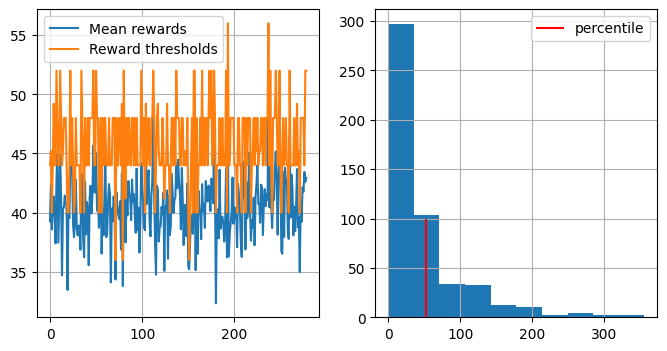

KeyboardInterrupt: 

In [1105]:
n_sessions = 500
percentile = 70
log = []

agent = ActionClassifier()
train_loop = get_train_loop(agent)


def normalize_rewards(rewards):
    rewards = np.array(rewards)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-8)
    return rewards


for i in range(1000):
    sessions = [generate_session() for _ in range(n_sessions)]
    states_batch, actions_batch, rewards_batch = zip(*sessions)
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    train_loop(elite_states, elite_actions)
    scheduler.step()
    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])
    